In [15]:
import os
import sys
module_path = os.path.abspath(os.path.join('../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from astir.data import from_csv_yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import torch
import math
import yaml
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import rand_score, accuracy_score, precision_score, f1_score

c:\Users\Localadmin_kangzigi\.conda\envs\astir\lib\site-packages\loompy\bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
c:\Users\Localadmin_kangzigi\.conda\envs\astir\lib\site-packages\loompy\bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def dna_to_twobit(dna: str) -> int:
c:\Users\L

In [29]:
# if save session
import dill
dill.dump_session('stellar_astir_benchmarking_env.db')

In [ ]:
# restore session
import dill
dill.load_session('stellar_astir_benchmarking_env.db')

# 1st Level - CL

In [21]:
expression_mat_path= 'C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\STELLAR\\input_data\\STELLAR_data_donor_004_upperlevel_CL.csv'
yaml_marker_path = "C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\STELLAR\\cell_type_descr_astir.yml"
output_path = "C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\STELLAR\\output_data\\Astir_benchmarking\\"

In [3]:
# ast = from_csv_yaml(expression_mat_path, marker_yaml=yaml_marker_path)
df_gex = pd.read_csv(expression_mat_path, low_memory=False)
cols = ['MUC2', 'SOX9', 'MUC1', 'CD31', 'Synapto', 'CD49f', 'CD15',
       'CHGA', 'CDX2', 'ITLN1', 'CD4', 'CD127', 'Vimentin', 'HLADR',
       'CD8', 'CD11c', 'CD44', 'CD16', 'BCL2', 'CD3', 'CD123', 'CD38',
       'CD90', 'aSMA', 'CD21', 'NKG2D', 'CD66', 'CD57', 'CD206', 'CD68',
       'CD34', 'aDef5', 'CD7', 'CD36', 'CD138', 'CD45RO', 'Cytokeratin',
       'CK7', 'CD117', 'CD19', 'Podoplanin', 'CD45', 'CD56', 'CD69',
       'Ki67', 'CD49a', 'CD163', 'CD161']

df_gex = df_gex[cols]
scaler = MinMaxScaler()
df_gex.loc[:,(cols)] = scaler.fit_transform(df_gex[cols])
from astir.astir import Astir
with open(yaml_marker_path, "r") as stream:
    marker_dict = yaml.safe_load(stream)
ast = Astir(df_gex, marker_dict)
print(ast)

Astir object, 4 cell types, 110633 cells


training restart (final):   1%|          | 7/1000 [ 3.01s/epochs, current loss: -4903898.2]


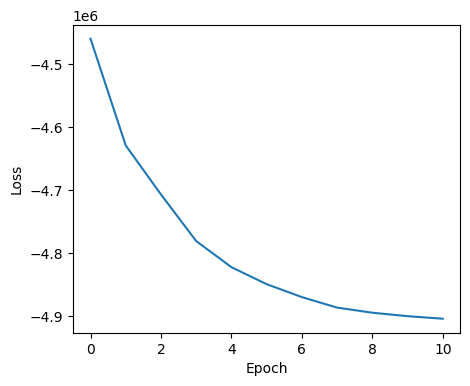

In [4]:
# Create batch size proportional to the number of cells

N = ast.get_type_dataset().get_exprs_df().shape[0]
batch_size = int(N/100)
# Number of training epochs
max_epochs = 1000
# Set learning rate
learning_rate = 2e-3
# Set initial epochs
initial_epochs = 3

ast.fit_type(max_epochs = max_epochs,
             batch_size = batch_size,
             learning_rate = learning_rate,
             n_init_epochs = initial_epochs)

# plot loss function
plt.figure(figsize=(5,4))
plt.plot(np.arange(len(ast.get_type_losses())), ast.get_type_losses())
plt.ylabel("Loss")
plt.xlabel("Epoch")

# get astir result
Astir_result = ast.get_celltypes()

In [22]:
Astir_result.to_csv("{}stellar_cl_lv1_benchmarking.csv".format(output_path))

<Axes: xlabel='Cell_type'>

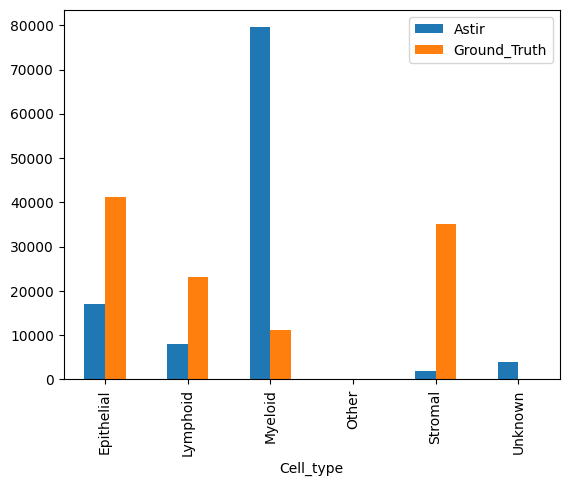

In [5]:
sample_data = pd.read_csv(expression_mat_path,low_memory=False)
Other_stat = pd.DataFrame(np.array(np.unique(list(Astir_result["cell_type"]), return_counts=True)).T, columns=("Cell_type", "Astir"))
Truth_stat = pd.DataFrame(np.array(np.unique(list(sample_data["cell_type_upperlevel"]), return_counts=True)).T, columns=("Cell_type", "Ground_Truth"))
Stat_merged = pd.merge(Other_stat, Truth_stat, how="outer", on=["Cell_type"])
Stat_merged["Astir"] = pd.to_numeric(Stat_merged["Astir"])
Stat_merged["Ground_Truth"] = pd.to_numeric(Stat_merged["Ground_Truth"])
Stat_merged.plot(x="Cell_type",
        kind='bar',
        stacked=False)

Rand score = 0.521632333606104, Accuracy score = 0.3296665551869695, Precision score = 0.8716586188614086, F1 score = 0.36762378896161474


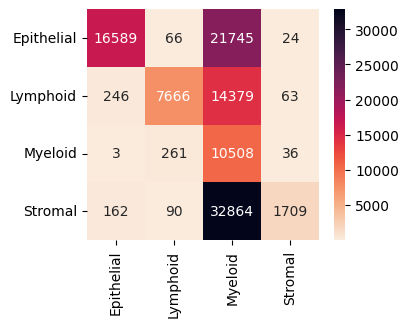

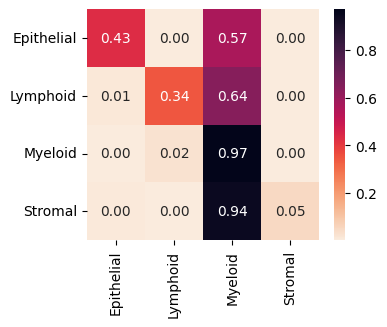

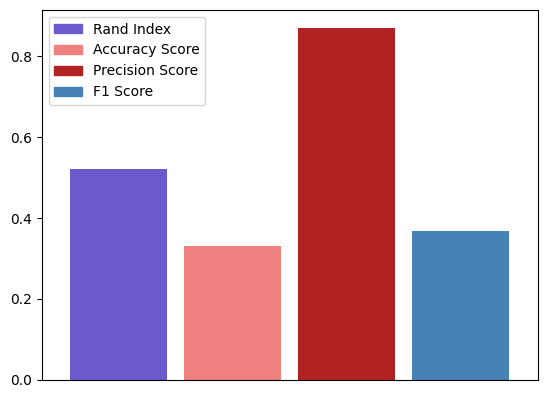

In [6]:
# "original_labels" list of the "ground_truth labels"

sample_data = pd.read_csv(expression_mat_path,low_memory=False)
original_labels = np.array(sample_data["cell_type_upperlevel"]).tolist()
astir_labels = list(Astir_result["cell_type"])
original_label_types = np.unique(original_labels)
tribus_labels = [ 'other_Global' if label == 'Unknown' or label == 'Other' else label for label in astir_labels]

cm = metrics.confusion_matrix(original_labels, astir_labels, labels=original_label_types)
df_cm = pd.DataFrame(cm, index = original_label_types,
                  columns = original_label_types)
fig, ax = plt.subplots(figsize = (len(np.unique(astir_labels))*0.625, len(np.unique(astir_labels))*0.5))         # Sample figsize in inches
sns.heatmap(df_cm, fmt='g', annot=True, cmap=sns.cm.rocket_r)

cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cmn = pd.DataFrame(cmn, index = original_label_types,
                  columns = original_label_types)
fig, ax = plt.subplots(figsize = (len(np.unique(astir_labels))*0.625, len(np.unique(astir_labels))*0.5)) 
sns.heatmap(df_cmn, fmt=".2f", annot=True, cmap=sns.cm.rocket_r)

# Calculate average accuracy metrics and visualization
RI_avg = rand_score(original_labels, astir_labels) #between 0-1
AS_avg = accuracy_score(original_labels, astir_labels)
PS_avg = precision_score(original_labels, astir_labels, average='weighted')
F1_avg = f1_score(original_labels, astir_labels, average="weighted")
print("Rand score = {}, Accuracy score = {}, Precision score = {}, F1 score = {}".format(RI_avg, AS_avg, PS_avg, F1_avg))
df = pd.DataFrame([RI_avg, AS_avg, PS_avg, F1_avg], columns=['Value'], index = ["Rand Index", "Accuracy Score", "Precision Score", "F1 Score"])

colors = {"Rand Index": 'slateblue', "Accuracy Score": 'lightcoral', "Precision Score": 'firebrick', "F1 Score":'steelblue'}
df.plot.bar(y='Value', width = 0.85, legend=False, 
            color=['slateblue', 'lightcoral', 'firebrick', 'steelblue'], rot=0, xticks=[])
metric_labels = ["Rand Index", "Accuracy Score", "Precision Score", "F1 Score"]
handles = [plt.Rectangle((0,0),1,1, color=colors[l]) for l in metric_labels]
plt.legend(handles, metric_labels)

               TN     FP     FN     TP  accuracy
Epithelial  69088    411  24545  16589  0.774425
Lymphoid    87029    417  15521   7666  0.855938
Myeloid     30531  68988    606  10508  0.370947
Stromal     75312    123  33489   1709  0.696185
              precision    recall  f1-score   support
Epithelial     0.975824  0.403292  0.570716   41134.0
Lymphoid       0.948410  0.330616  0.490310   23187.0
Myeloid        0.132183  0.945474  0.231939   11114.0
Stromal        0.932860  0.048554  0.092304   35198.0
micro avg      0.342747  0.329667  0.336079  110633.0
macro avg      0.747319  0.431984  0.346317  110633.0
weighted avg   0.871659  0.329667  0.367624  110633.0


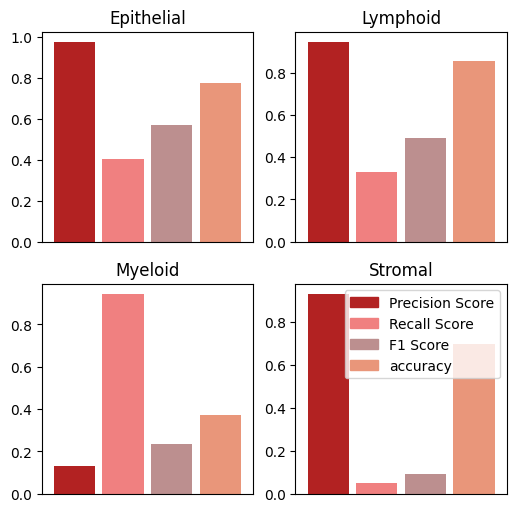

In [14]:
# accuracy metrics per cell type
celltype_pred = astir_labels
celltype_true = original_labels

classes = np.intersect1d(np.unique(celltype_pred), np.unique(celltype_true))

stats_array = metrics.multilabel_confusion_matrix(celltype_true, celltype_pred, labels=classes)
stats_df = pd.DataFrame()
for i in range(len(stats_array)):
    stats_df = pd.concat([stats_df, pd.DataFrame(stats_array[i].flatten()).T])
stats_df.columns = ["TN", "FP", "FN", "TP"]
stats_df.index = [classes]
stats_df["accuracy"] = (stats_df["TN"] + stats_df["TP"]) / (stats_df["TN"] + stats_df["TP"] + stats_df["FN"] + stats_df["FP"]) # in celesta paper they use this way to calculate Rand Index
print(stats_df)

report = metrics.classification_report(celltype_true, celltype_pred, labels=classes, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(report_df)
# Support is the number of actual occurrences of the class in the specified dataset.

rows = math.ceil(len(np.intersect1d(np.unique(celltype_pred), np.unique(celltype_true))) / 2)
fig, ax = plt.subplots(rows, 2, figsize=(6,6))

for i in range(len(np.intersect1d(np.unique(celltype_pred), np.unique(celltype_true)))): 
    
    celltype = np.intersect1d(np.unique(celltype_pred), np.unique(celltype_true))[i]
    df = report_df.loc[celltype]
    df["accuracy"] = stats_df.iloc[i,-1].tolist()
    df = df[["precision", "recall", "f1-score", "accuracy"]]
    
    colors = {"Precision Score": 'firebrick', "Recall Score": 'lightcoral', "F1 Score":'rosybrown', "accuracy": 'darksalmon'}
    df.plot.bar(y='Value', ax=ax[int(i / 2)][i % 2], width = 0.85, 
                title="{}".format(celltype), legend=False, 
                color=['firebrick', 'lightcoral', 'rosybrown', 'darksalmon'], rot=0, xticks=[])

metric_labels = ["Precision Score", "Recall Score", "F1 Score", "accuracy"]
handles = [plt.Rectangle((0,0),1,1, color=colors[l]) for l in metric_labels]
plt.legend(handles, metric_labels)
plt.show()

# 1st Level - SB

In [134]:
expression_mat_path= 'C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\STELLAR\\input_data\\STELLAR_data_donor_004_upperlevel_SB.csv'
yaml_marker_path = "C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\STELLAR\\cell_type_descr_astir.yml"

In [135]:
# ast = from_csv_yaml(expression_mat_path, marker_yaml=yaml_marker_path)
df_gex = pd.read_csv(expression_mat_path, low_memory=False)
cols = ['MUC2', 'SOX9', 'MUC1', 'CD31', 'Synapto', 'CD49f', 'CD15',
       'CHGA', 'CDX2', 'ITLN1', 'CD4', 'CD127', 'Vimentin', 'HLADR',
       'CD8', 'CD11c', 'CD44', 'CD16', 'BCL2', 'CD3', 'CD123', 'CD38',
       'CD90', 'aSMA', 'CD21', 'NKG2D', 'CD66', 'CD57', 'CD206', 'CD68',
       'CD34', 'aDef5', 'CD7', 'CD36', 'CD138', 'CD45RO', 'Cytokeratin',
       'CK7', 'CD117', 'CD19', 'Podoplanin', 'CD45', 'CD56', 'CD69',
       'Ki67', 'CD49a', 'CD163', 'CD161']

df_gex = df_gex[cols]
scaler = MinMaxScaler()
df_gex.loc[:,(cols)] = scaler.fit_transform(df_gex[cols])
from astir.astir import Astir
with open(yaml_marker_path, "r") as stream:
    marker_dict = yaml.safe_load(stream)
ast = Astir(df_gex, marker_dict)
print(ast)

Astir object, 4 cell types, 137652 cells


In [136]:
# Create batch size proportional to the number of cells

N = ast.get_type_dataset().get_exprs_df().shape[0]
batch_size = int(N/100)
# Number of training epochs
max_epochs = 1000
# Set learning rate
learning_rate = 2e-3
# Set initial epochs
initial_epochs = 3

ast.fit_type(max_epochs = max_epochs,
             batch_size = batch_size,
             learning_rate = learning_rate,
             n_init_epochs = initial_epochs)

training restart (final):   1%|          | 8/1000 [ 4.25s/epochs, current loss: -6655162.1]


Text(0.5, 0, 'Epoch')

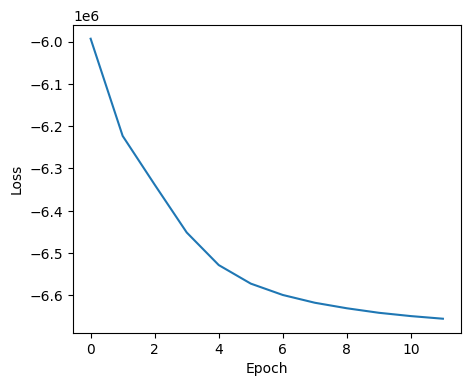

In [137]:
plt.figure(figsize=(5,4))
plt.plot(np.arange(len(ast.get_type_losses())), ast.get_type_losses())
plt.ylabel("Loss")
plt.xlabel("Epoch")

In [138]:
Astir_result = ast.get_celltypes()

<Axes: xlabel='Cell_type'>

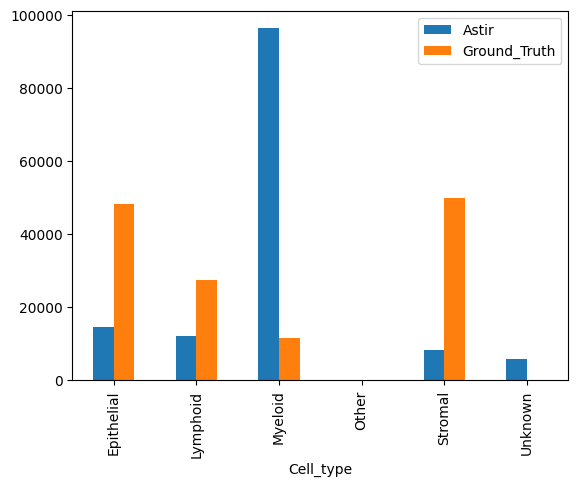

In [139]:
sample_data = pd.read_csv(expression_mat_path,low_memory=False)
Other_stat = pd.DataFrame(np.array(np.unique(list(Astir_result["cell_type"]), return_counts=True)).T, columns=("Cell_type", "Astir"))
Truth_stat = pd.DataFrame(np.array(np.unique(list(sample_data["cell_type_upperlevel"]), return_counts=True)).T, columns=("Cell_type", "Ground_Truth"))
Stat_merged = pd.merge(Other_stat, Truth_stat, how="outer", on=["Cell_type"])
Stat_merged["Astir"] = pd.to_numeric(Stat_merged["Astir"])
Stat_merged["Ground_Truth"] = pd.to_numeric(Stat_merged["Ground_Truth"])
Stat_merged.plot(x="Cell_type",
        kind='bar',
        stacked=False)

<Axes: >

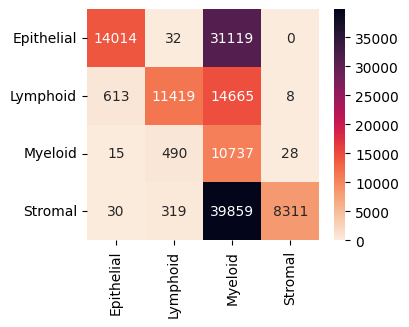

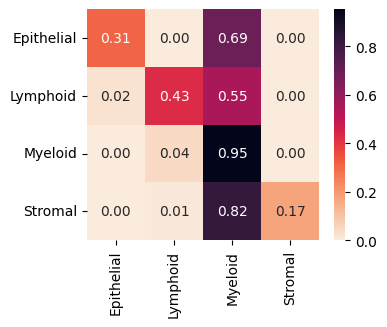

In [140]:
# "original_labels" list of the "ground_truth labels"

sample_data = pd.read_csv(expression_mat_path,low_memory=False)
original_labels = np.array(sample_data["cell_type_upperlevel"]).tolist()
astir_labels = list(Astir_result["cell_type"])
original_label_types = np.unique(original_labels)
tribus_labels = [ 'other_Global' if label == 'Unknown' or label == 'Other' else label for label in astir_labels]

cm = metrics.confusion_matrix(original_labels, astir_labels, labels=original_label_types)
df_cm = pd.DataFrame(cm, index = original_label_types,
                  columns = original_label_types)
fig, ax = plt.subplots(figsize = (len(np.unique(astir_labels))*0.625, len(np.unique(astir_labels))*0.5))         # Sample figsize in inches
sns.heatmap(df_cm, fmt='g', annot=True, cmap=sns.cm.rocket_r)

cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cmn = pd.DataFrame(cmn, index = original_label_types,
                  columns = original_label_types)
fig, ax = plt.subplots(figsize = (len(np.unique(astir_labels))*0.625, len(np.unique(astir_labels))*0.5)) 
sns.heatmap(df_cmn, fmt=".2f", annot=True, cmap=sns.cm.rocket_r)


# 2nd level - CL

In [1]:
expression_mat_path= 'C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\STELLAR\\input_data\\STELLAR_data_donor_004_upperlevel_CL.csv'
yaml_marker_path = "C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\STELLAR\\cell_type_descr_astir_2lelvel.yml"
output_path = "C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\STELLAR\\output_data\\Astir_benchmarking\\"

In [5]:
# ast = from_csv_yaml(expression_mat_path, marker_yaml=yaml_marker_path)
df_gex = pd.read_csv(expression_mat_path, low_memory=False)
cols = ['MUC2', 'SOX9', 'MUC1', 'CD31', 'Synapto', 'CD49f', 'CD15',
       'CHGA', 'CDX2', 'ITLN1', 'CD4', 'CD127', 'Vimentin', 'HLADR',
       'CD8', 'CD11c', 'CD44', 'CD16', 'BCL2', 'CD3', 'CD123', 'CD38',
       'CD90', 'aSMA', 'CD21', 'NKG2D', 'CD66', 'CD57', 'CD206', 'CD68',
       'CD34', 'aDef5', 'CD7', 'CD36', 'CD138', 'CD45RO', 'Cytokeratin',
       'CK7', 'CD117', 'CD19', 'Podoplanin', 'CD45', 'CD56', 'CD69',
       'Ki67', 'CD49a', 'CD163', 'CD161']

df_gex = df_gex[cols]
scaler = MinMaxScaler()
df_gex.loc[:,(cols)] = scaler.fit_transform(df_gex[cols]) # otherwise cannot run 
df_gex.loc[:,(cols)] = np.arcsinh(df_gex[cols]/5)
from astir.astir import Astir
with open(yaml_marker_path, "r") as stream:
    marker_dict = yaml.safe_load(stream)
ast = Astir(df_gex, marker_dict)
print(ast)

Astir object, 14 cell types, 110633 cells


In [6]:
# Create batch size proportional to the number of cells

N = ast.get_type_dataset().get_exprs_df().shape[0]
batch_size = int(N/100)
# Number of training epochs
max_epochs = 1000
# Set learning rate
learning_rate = 2e-3
# Set initial epochs
initial_epochs = 3

ast.fit_type(max_epochs = max_epochs,
             batch_size = batch_size,
             learning_rate = learning_rate,
             n_init_epochs = initial_epochs)

# get astir result
Astir_result = ast.get_celltypes()

training restart (final):   1%|▏         | 13/1000 [ 6.31s/epochs, current loss: -16150731.3]


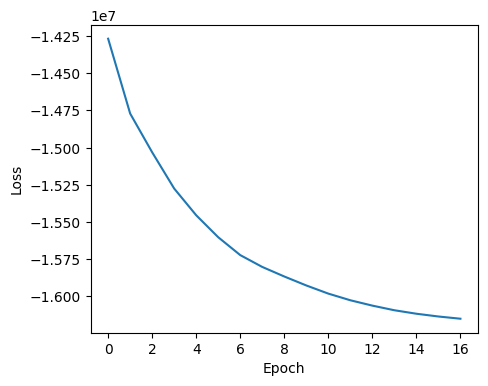

In [7]:
plt.figure(figsize=(5,4))
plt.plot(np.arange(len(ast.get_type_losses())), ast.get_type_losses())
plt.ylabel("Loss")
plt.xlabel("Epoch")

plt.savefig("{}stellar_cl_lossfunc.svg".format(output_path))
plt.show()

In [8]:
Astir_result.to_csv("{}stellar_cl_lv2_benchmarking.csv".format(output_path))

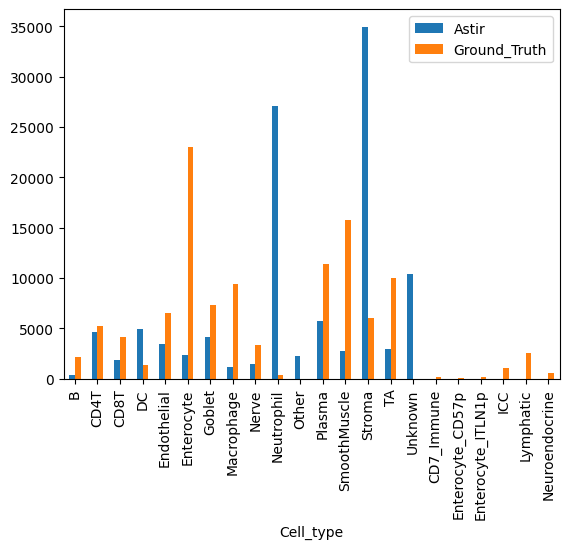

In [9]:
sample_data = pd.read_csv(expression_mat_path,low_memory=False)
Other_stat = pd.DataFrame(np.array(np.unique(list(Astir_result["cell_type"]), return_counts=True)).T, columns=("Cell_type", "Astir"))
Truth_stat = pd.DataFrame(np.array(np.unique(list(sample_data["cell_type_A"]), return_counts=True)).T, columns=("Cell_type", "Ground_Truth"))
Stat_merged = pd.merge(Other_stat, Truth_stat, how="outer", on=["Cell_type"])
Stat_merged["Astir"] = pd.to_numeric(Stat_merged["Astir"])
Stat_merged["Ground_Truth"] = pd.to_numeric(Stat_merged["Ground_Truth"])
Stat_merged.plot(x="Cell_type",
        kind='bar',
        stacked=False)

plt.savefig("{}stellar_cl_num_level2.svg".format(output_path))
plt.show()

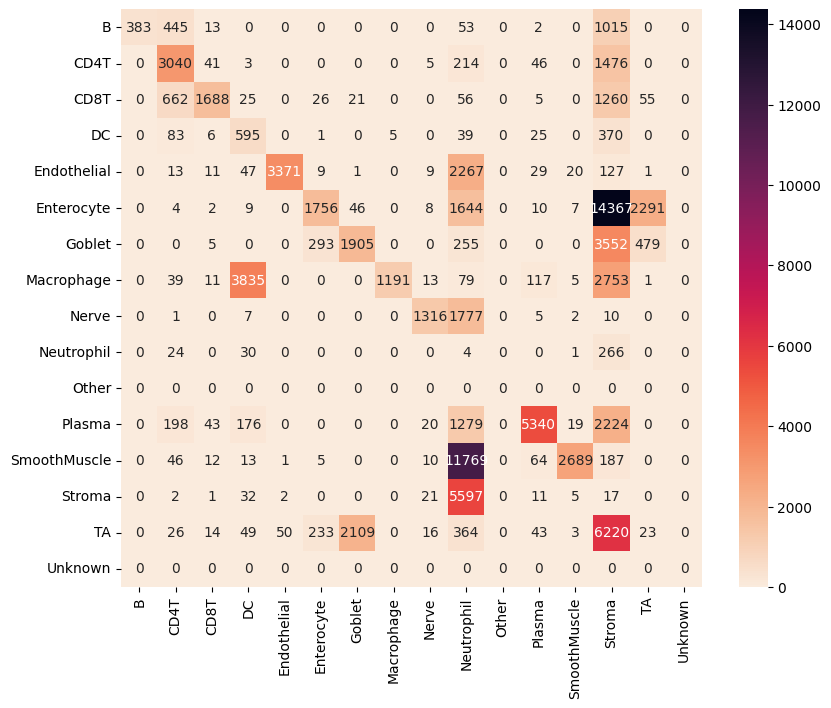

C:\Users\Localadmin_kangzigi\AppData\Local\Temp\ipykernel_20656\2762952014.py:19: RuntimeWarning: invalid value encountered in divide
  cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


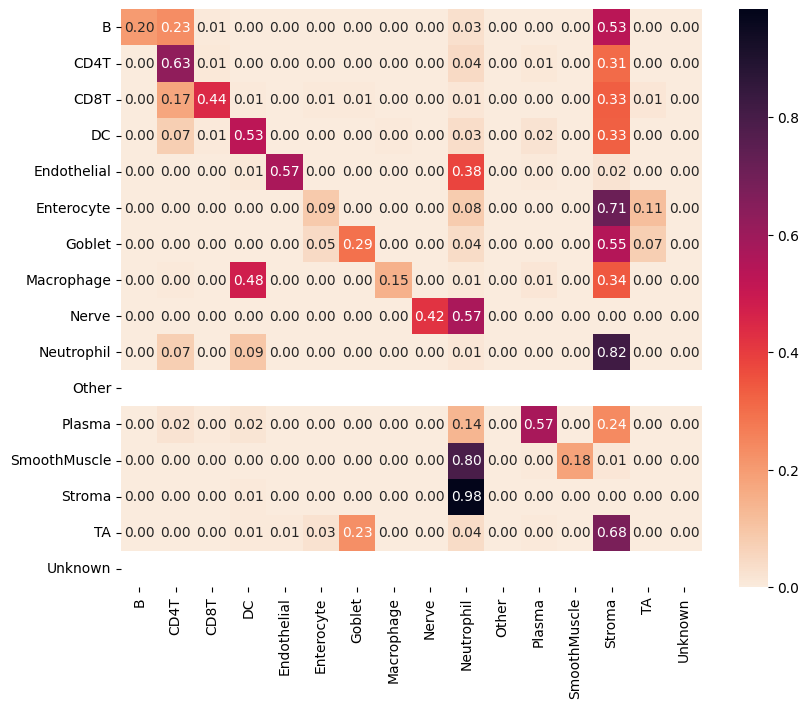

c:\Users\Localadmin_kangzigi\.conda\envs\astir\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Rand score = 0.8034094744503736, Accuracy score = 0.2107689387434129, Precision score = 0.6778941385523995, F1 score = 0.2910184080711916


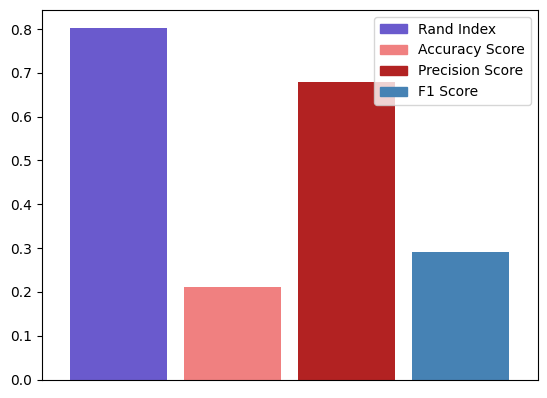

In [10]:
# "original_labels" list of the "ground_truth labels"
from sklearn.metrics import rand_score, accuracy_score, precision_score, f1_score

sample_data = pd.read_csv(expression_mat_path,low_memory=False)
original_labels = np.array(sample_data["cell_type_A"]).tolist()
astir_labels = list(Astir_result["cell_type"])
original_label_types = np.unique(astir_labels)
astir_labels = [ 'other_Global' if label == 'Unknown' or label == 'Other' else label for label in astir_labels]

cm = metrics.confusion_matrix(original_labels, astir_labels, labels=original_label_types)
df_cm = pd.DataFrame(cm, index = original_label_types,
                  columns = original_label_types)
fig, ax = plt.subplots(figsize = (len(np.unique(astir_labels))*0.625, len(np.unique(astir_labels))*0.5))         # Sample figsize in inches
sns.heatmap(df_cm, fmt='g', annot=True, cmap=sns.cm.rocket_r)

plt.savefig("{}stellar_cl_cm_level2.svg".format(output_path))
plt.show()

cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cmn = pd.DataFrame(cmn, index = original_label_types,
                  columns = original_label_types)
fig, ax = plt.subplots(figsize = (len(np.unique(astir_labels))*0.625, len(np.unique(astir_labels))*0.5)) 
sns.heatmap(df_cmn, fmt=".2f", annot=True, cmap=sns.cm.rocket_r)

plt.savefig("{}stellar_cl_cmn_level2.svg".format(output_path))
plt.show()

# Calculate average accuracy metrics and visualization
RI_avg = rand_score(original_labels, astir_labels) #between 0-1
AS_avg = accuracy_score(original_labels, astir_labels)
PS_avg = precision_score(original_labels, astir_labels, average='weighted')
F1_avg = f1_score(original_labels, astir_labels, average="weighted")
print("Rand score = {}, Accuracy score = {}, Precision score = {}, F1 score = {}".format(RI_avg, AS_avg, PS_avg, F1_avg))
df = pd.DataFrame([RI_avg, AS_avg, PS_avg, F1_avg], columns=['Value'], index = ["Rand Index", "Accuracy Score", "Precision Score", "F1 Score"])

df.to_csv("{}stellar_cl_benchmarking_stats_report_all.csv".format(output_path))

colors = {"Rand Index": 'slateblue', "Accuracy Score": 'lightcoral', "Precision Score": 'firebrick', "F1 Score":'steelblue'}
df.plot.bar(y='Value', width = 0.85, legend=False, 
            color=['slateblue', 'lightcoral', 'firebrick', 'steelblue'], rot=0, xticks=[])
metric_labels = ["Rand Index", "Accuracy Score", "Precision Score", "F1 Score"]
handles = [plt.Rectangle((0,0),1,1, color=colors[l]) for l in metric_labels]
plt.legend(handles, metric_labels)

plt.savefig("{}stellar_cl_metrics_average.svg".format(output_path))
plt.show()


                  TN     FP     FN    TP  accuracy
B             108431      0   1819   383  0.983558
CD4T          103787   1587   2219  3040  0.965598
CD8T          106347    159   2439  1688  0.976517
DC            104895   4396    747   595  0.953513
Endothelial   104076     53   3133  3371  0.971202
Enterocyte     87053    598  21226  1756  0.802735
Goblet        101003   2274   5451  1905  0.930175
Macrophage    101254      7   8181  1191  0.925990
Nerve         107186    118   2013  1316  0.980738
Neutrophil     83112  27121    396     4  0.751277
Plasma         98845    363   6085  5340  0.941717
SmoothMuscle   94839     65  13040  2689  0.881545
Stroma         69629  34949   6038    17  0.629523
TA             97655   2957   9998    23  0.882901
              precision    recall  f1-score   support
B              1.000000  0.173933  0.296325    2202.0
CD4T           0.657013  0.578057  0.615011    5259.0
CD8T           0.913914  0.409014  0.565116    4127.0
DC             0.11

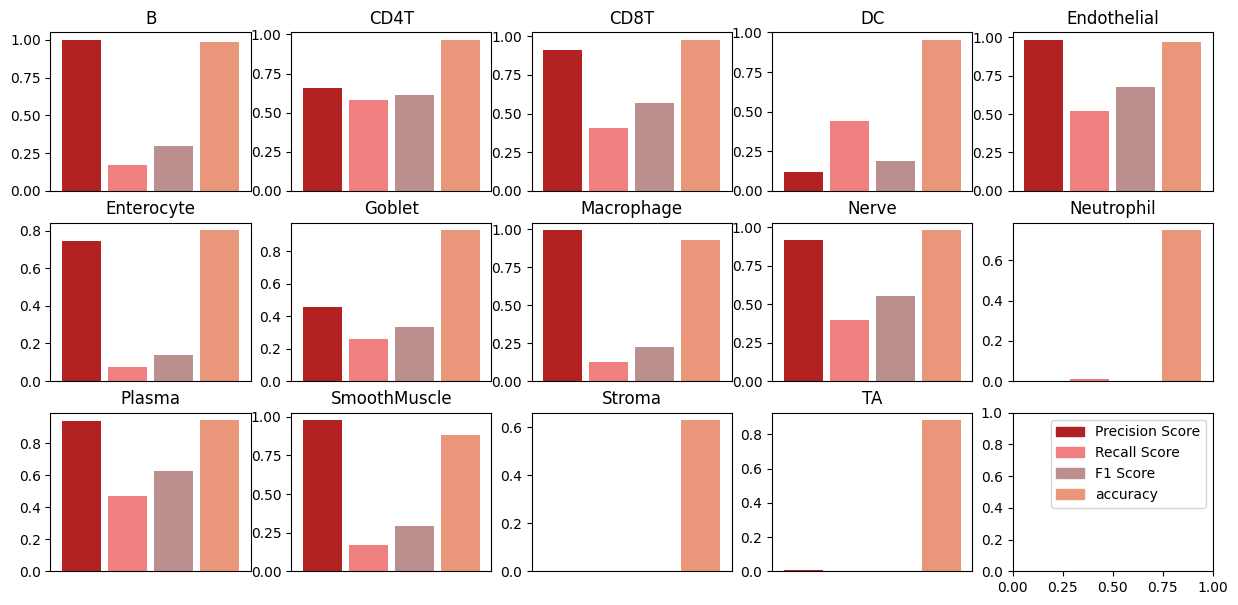

In [11]:
# accuracy metrics per cell type
celltype_pred = astir_labels
celltype_true = original_labels

classes = np.intersect1d(np.unique(celltype_pred), np.unique(celltype_true))

stats_array = metrics.multilabel_confusion_matrix(celltype_true, celltype_pred, labels=classes)
stats_df = pd.DataFrame()
for i in range(len(stats_array)):
    stats_df = pd.concat([stats_df, pd.DataFrame(stats_array[i].flatten()).T])
stats_df.columns = ["TN", "FP", "FN", "TP"]
stats_df.index = [classes]
stats_df["accuracy"] = (stats_df["TN"] + stats_df["TP"]) / (stats_df["TN"] + stats_df["TP"] + stats_df["FN"] + stats_df["FP"]) # in celesta paper they use this way to calculate Rand Index
print(stats_df)
stats_df.to_csv("{}stellar_cl_benchmarking_stats.csv".format(output_path))

report = metrics.classification_report(celltype_true, celltype_pred, labels=classes, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(report_df)
report_df.to_csv("{}stellar_cl_benchmarking_stats_report.csv".format(output_path))
# Support is the number of actual occurrences of the class in the specified dataset.

rows = math.ceil(len(np.intersect1d(np.unique(celltype_pred), np.unique(celltype_true))) / 5)
fig, ax = plt.subplots(rows, 5, figsize=(15,7))

for i in range(len(np.intersect1d(np.unique(celltype_pred), np.unique(celltype_true)))): 
    
    celltype = np.intersect1d(np.unique(celltype_pred), np.unique(celltype_true))[i]
    df = report_df.loc[celltype]
    df["accuracy"] = stats_df.iloc[i,-1].tolist()
    df = df[["precision", "recall", "f1-score", "accuracy"]]
    
    colors = {"Precision Score": 'firebrick', "Recall Score": 'lightcoral', "F1 Score":'rosybrown', "accuracy": 'darksalmon'}
    df.plot.bar(y='Value', ax=ax[int(i / 5)][i % 5], width = 0.85, 
                title="{}".format(celltype), legend=False, 
                color=['firebrick', 'lightcoral', 'rosybrown', 'darksalmon'], rot=0, xticks=[])

metric_labels = ["Precision Score", "Recall Score", "F1 Score", "accuracy"]
handles = [plt.Rectangle((0,0),1,1, color=colors[l]) for l in metric_labels]
plt.legend(handles, metric_labels)

plt.savefig("{}stellar_cl_metrics_per_celltype.svg".format(output_path))
plt.show()